# Kaggle - Neuroimaging 

Two forms of data, images and tabular data, are provided for this competition. The tabular datasets are used to build the model for predicting the assessment for multiple domains and the age. The features are derived from the MRI images. Some of the subjects in test dataset are from a site different from the training set to build a more generalized model. The records in train_scores.csv are not the raw assessment value, they are transformed for privacy and ethicality reason. The target variable, age, is rounded to nearest year in the training set but, the age in the test dataset for evaluation are not rounded and recorded at a higher precision. Therefore, there is risk of overfitting. Evaluation metrics is given and being defined by the function 'metrics', in the 'Function Definition' section. Different weights are assigned to the variables. 

### Datasets

fnc.csv - static FNC correlation features for both train and test samples 

loading.csv - sMRI SBM loadings for both train and test samples 

train_scores.csv - age and assessment values for train samples 

### Library Loading 

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.svm import SVR
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import make_scorer
import time
import warnings
warnings.filterwarnings('ignore')

### Function Definition 

In [2]:
def min_max(var):
    iqr = np.nanquantile(train_scores[var], 0.75) - np.nanquantile(train_scores[var], 0.25)
    lb = np.nanquantile(train_scores[var], 0.25) - 1.5*iqr
    ub = np.nanquantile(train_scores[var], 0.75) + 1.5*iqr
    
    return (lb, ub)

def metrics(y, y_hat):
    score = np.mean(np.sum(np.abs(y - y_hat), axis = 0)/np.sum(y_hat, axis = 0))
    return (score)

def load_data(is_train=True):
    path = '/Users/hshan/Downloads'
    fnc = pd.read_csv(f'{path}/fnc.csv')
    loading = pd.read_csv(f'{path}/loading.csv')
    train_scores = pd.read_csv(f'{path}/train_scores.csv')
    
    fnc[fnc_features] *= 0.0035
    # rescaling fnc dataframe

    features_df = fnc.merge(loading, on = 'Id')
    train_scores['is_train'] = True
    df = features_df.merge(train_scores, how='left')

    df['is_train'].fillna(False, inplace = True)
    
    if not is_train:
        df = df[df['is_train']==False]
        df.drop('is_train', axis=1, inplace= True)
    else:
        df = df[df['is_train']==True]
        df.drop('is_train', axis=1, inplace= True)
    
    return df


In [3]:
def train_predict(train_df, test_df, n=7):
    
    # weights for metrics is given 
    weights = {
            'age': 0.3, 
            'domain1_var1': 0.175, 
            'domain1_var2': 0.175, 
            'domain2_var1': 0.175, 
            'domain2_var2': 0.175
            }

    g = {
            'age': 100, 
            'domain1_var1': 100, 
            'domain1_var2': 100, 
            'domain2_var1': 100, 
            'domain2_var2': 20
            }

    c = {
            'age': 60, 
            'domain1_var1': 12, 
            'domain1_var2': 8, 
            'domain2_var1': 8, 
            'domain2_var2': 12
            }
    
    a = {
            'age':0.08, 
            'domain1_var1': 2, 
            'domain1_var2': 2, 
            'domain2_var1': 2, 
            'domain2_var2': 2
            }
    
    prediction = pd.DataFrame(test_df['Id'])
    tot_scores = 0
    ridge_tot_scores = 0

    kf = KFold(n_splits=n, shuffle=True, random_state=1231)

    for var in target_var:
        scores = 0
        pred = 0
        ridge_pred = 0
        ridge_scores = 0
        
        lb, ub = min_max(var)[0], min_max(var)[1]
        
        # trimming and locating null
        tr_df = train_df.loc[(train_df[var]>lb) & (train_df[var]<ub)]
        null_df = train_df[train_df[var].isnull()]
        tr_df = tr_df.append(null_df)
        
        # imputing 
        fill = 0.5*(tr_df[var].mean() + tr_df[var].median())
        tr_df = tr_df.fillna(fill)
    
        x = tr_df[features_cols]
        y= tr_df[var]
    
        for train_index, test_index in kf.split(tr_df):
            xTrain, xTest = x.iloc[train_index], x.iloc[test_index]
            yTrain, yTest = y.iloc[train_index], y.iloc[test_index]
     
            model = SVR(C=c[var], cache_size=3000, gamma=g[var], epsilon=3.5)
            model.fit(xTrain, yTrain)
            y_hat = model.predict(xTest)
    
            scores += metrics(y=yTest, y_hat = y_hat)
        
            #ridge
            ridge = Ridge(alpha=a[var], normalize = True)
            ridge.fit(xTrain, yTrain)
            ridge_y_hat = ridge.predict(xTest)

            ridge_scores += metrics(y=yTest, y_hat = ridge_y_hat)
            
            #lasso
#             lasso = Lasso(alpha=2, max_iter=10e5)
#             lasso.fit(xTrain, yTrain)
#             lasso_y_hat = lasso.predict(xTest)
 
#             lasso_scores += metrics(y=yTest, y_hat = lasso_y_hat)

            pred += model.predict(test_df[features_cols])
            ridge_pred += ridge.predict(test_df[features_cols])   
#             lasso_pred += lasso.predict(test_df[features_cols])
    
        prediction[f'ridge_{var}'] = ridge_pred/n
        prediction[var] = pred/n
#         lasso_tot_scores += weights[label]*(lasso_scores/n)

        tot_scores += weights[var]*(scores/n)
        ridge_tot_scores += weights[var]*(ridge_scores/n)
#         print(label, ': ', lasso_scores/n)

        print(var, ': ', scores/n)    
        print(var, ': ', ridge_scores/n)
#         print('lasso overall score: ', round(ridge_tot_scores,5))

    print('score: ', 0.75*tot_scores + 0.25*ridge_tot_scores)

    return prediction

def submission(prediction):
    for var in target_var:
#         prediction[var] = prediction[[var,f'ridge_{var}']].mean(axis=1)
        prediction[var] = 1.008*(0.75*prediction[var]+0.25*prediction[f'ridge_{var}'])
        prediction.drop(f'ridge_{var}', axis=1, inplace=True)
    
    prediction= pd.melt(prediction, id_vars =['Id'], value_vars = target_var) 

    prediction['Id'] = prediction['Id'].astype('str') + '_' + prediction['variable'].astype('str') 
    prediction.drop('variable', axis = 1, inplace = True)
    prediction.rename(columns = {'value':'Predicted'}, inplace = True)
    
    return prediction

def save(prediction, path, filename):
    dir = f'{path}/{filename}'
    prediction.to_csv(dir, index=False)

### Data Loading 

In [4]:
print('Data loading')

path = '/Users/hshan/Downloads'
fnc = pd.read_csv(f'{path}/fnc.csv')
loading = pd.read_csv(f'{path}/loading.csv')
train_scores = pd.read_csv(f'{path}/train_scores.csv')

print('Loading complete')

Data loading
Loading complete


### Data Exploration

In [5]:
print('--- Dimension of Data ---')
print()
print('FNC Dataframe: ', fnc.shape)
print('SMB Loading Dataframe: ', loading.shape)
print('SMB Loading Dataframe: ', train_scores.shape)

--- Dimension of Data ---

FNC Dataframe:  (11754, 1379)
SMB Loading Dataframe:  (11754, 27)
Target Dataframe:  (5877, 6)


In [6]:
print(' --- Listing headers of each table --- ')

fnc_features = fnc.columns.tolist()
fnc_features.remove('Id')
print( 'FNC features listed!')

loading_features = loading.columns.tolist()
loading_features.remove('Id')
print( 'SMB loading features listed!')

features_cols = fnc_features + loading_features

target_var = train_scores.columns.tolist()
target_var.remove('Id')
print( 'Target varibales listed!')

 --- Listing headers of each table --- 
FNC features listed!
SMB loading features listed!
Target varibales listed!


Since this is a quantitative data, and I am working on the regression problem, boxplot is a good tool to initialize the visualization. 

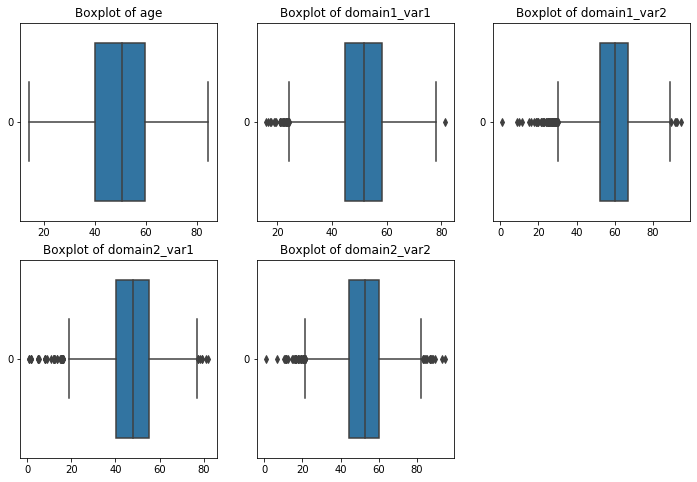

In [7]:
nvar = len(target_var)
ncols = 3

if nvar%ncols != 0:
    nrows = nvar//ncols + 1
else:
    nrows = nvar//ncols

f, axes = plt.subplots(nrows,ncols, figsize=(12, 8))


for i, var in enumerate(target_var):
    row = i//ncols
    col = i%ncols
    sns.boxplot(data = train_scores[var], orient = 'h', ax=axes[row][col]).set_title(f'Boxplot of {var}')

f.delaxes(axes[row][col+1])


The boxplots above showed that there is no obvious skewness for every target variables, the distribution is pretty symmetric. 
There are outliers present in the data, except for AGE. The data points are prefectly within the reasonable range for AGE. The minimum and maximum for each variables are computed such that

* minimum = first_quantile - 1.5*(IQR)
* maximum = third_quantile + 1.5*(IQR)

The data points beyond the minimum and maximum (two verticle lines on both tails of boxplot) are classified as outliers. Options considered for outliers treatment are: 

* trimming 
* top and bottom coding (capping the value at maximum and minimum computed based on the dataset)

NOTE: NULL is ignored in this computation. 

In [8]:
n_train = train_scores.shape[0]

for label in target_var:
    boundary = min_max(label)
    lower = (train_scores[label]<boundary[0]).sum()
    upper = (train_scores[label]>boundary[1]).sum()
    
    print(f'Min for {label}: ', boundary[0])
    print(f'Max for {label}: ', boundary[1])
    print('Number of data points beyond boundaries: ', lower+upper)
    print('Percentage of data points beyond boundaries: ', round((lower+upper)*100/n_train, 2), '%')
    print()

Min for age:  10.9521256473469
Max for age:  88.7580856784469
Number of data points beyond boundaries:  0
Percentage of data points beyond boundaries:  0.0 %

Min for domain1_var1:  24.2097372897478
Max for domain1_var1:  79.0670790616042
Number of data points beyond boundaries:  30
Percentage of data points beyond boundaries:  0.51 %

Min for domain1_var2:  30.27809488809176
Max for domain1_var2:  89.26132052043333
Number of data points beyond boundaries:  84
Percentage of data points beyond boundaries:  1.43 %

Min for domain2_var1:  17.71968520484416
Max for domain2_var1:  77.46101075008454
Number of data points beyond boundaries:  63
Percentage of data points beyond boundaries:  1.07 %

Min for domain2_var2:  21.42198101819453
Max for domain2_var2:  83.00304438459553
Number of data points beyond boundaries:  80
Percentage of data points beyond boundaries:  1.36 %



Referring to the information computed above, the number of outliers for each target variable is relatively small, overall occupied 2% of total data points. Hence, trimming is reasonable to be opted for easing the work. (The other option may be considered, by comparing the effectiveness of the models build.)

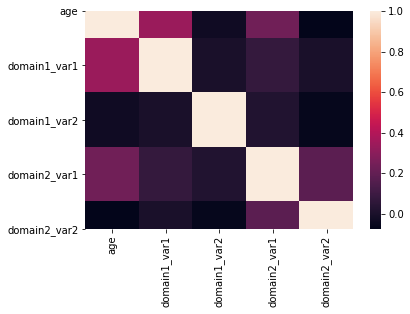

In [9]:
sns.heatmap(train_scores[target_var].corr()) 

From the heatmap, there is no strong correlation between the variables. The possible presences of weak correlations, around <0.4, were further investigated by observing the scatter plots. And, no obvious linear relationship is spotted.  

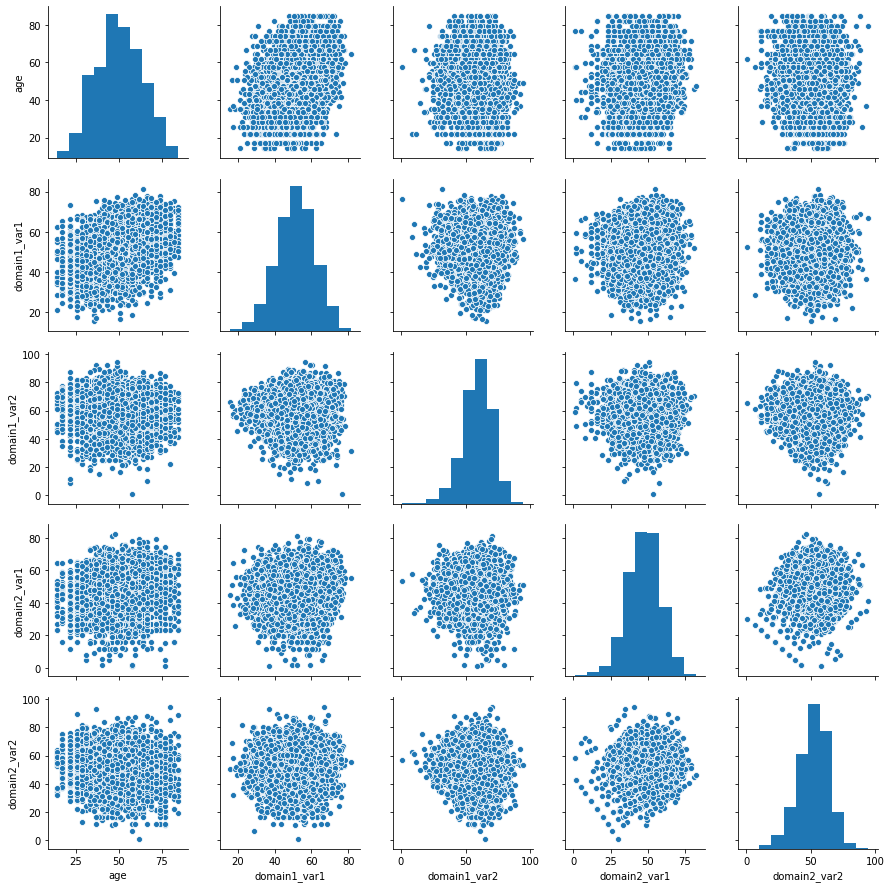

In [10]:
sns.pairplot(train_scores[target_var])

The matrix of scatter plots show that there is no linear relation between the variables, even there is small value of correlation observed from the heatmap. 

### Checking for null: 

In [11]:
null_count = pd.Series([train_scores[label].isnull().sum() for label in target_var])
null_percent = pd.Series([train_scores[label].isnull().sum()*100/n_train for label in target_var])
null_check = pd.concat([pd.Series(target_var), null_count, round(null_percent,2)], ignore_index = True, axis = 1)
null_check.columns = ['Variables', 'Null_Count', 'Null_Percentage']

display(null_check)

,Variables,Null_Count,Null_Percentage
0,age,0,0.00
1,domain1_var1,438,7.45
2,domain1_var2,438,7.45
3,domain2_var1,39,0.66
4,domain2_var2,39,0.66


Since I have only 5877 training data, the proportion of null of 7% is quite large that, I decided to do imputation, instead of removing the tuples with null. Imputation is done by filling the null as 

* fill_NaN = (mean + median)/2 

When we have symmetric data, we know that mean = median, I am judging the skewness by observing the boxplot, so to compensated the possible slight deviation of median from mean for each target variable, I computed the average between mean and median. (Median is more robust statistic)


In [12]:
print('Minimum of FNC data: ', min(fnc[fnc_features].min()))
print('Maximum of FNC data: ', max(fnc[fnc_features].max()))
print('Minimum of Loading data: ', min(loading[loading_features].min()))
print('Maximum of Loading data: ', max(loading[loading_features].max()))

Minimum of FNC data:  -0.96089453
Maximum of FNC data:  0.99222054
Minimum of Loading data:  -0.040384
Maximum of Loading data:  0.075813


Considering of applying support vector regression to solve the problem, scales may cause bias in the model build, since the range of the data differs too much. The explanatory variables need to be scaled by multiplying with a constant. After checking, there is no NULL value in the explanatory datasets. It stated that the features are obtained by ICA, so it is obvious that the features are statistically independent. There is no further analysis needed. 

### Data Processing

SVR did not work well with StandardScaler and MinMaxScaler in this case, it gave a result of identical prediction for all datapoints. The FNC data was rescaled by multiplying a constant.  

In [13]:
train_df = load_data(is_train=True)
test_df = load_data(is_train=False)

### Model Training and Predicting Test Data

In [14]:
start = time.time()

prediction = train_predict(train_df, test_df, n=7)
save(submission(prediction), path, 'submission.csv')

stop = time.time()

print('Time: ', (stop - start)/3600, 'hour(s)')

age :  0.14231102971070517
age :  0.14543042102020745
domain1_var1 :  0.14128243374869495
domain1_var1 :  0.14145107358753697
domain1_var2 :  0.13314875423263825
domain1_var2 :  0.13417119220305493
domain2_var1 :  0.1718277455417054
domain2_var1 :  0.17367823231241936
domain2_var2 :  0.16498764779568095
domain2_var2 :  0.16695541848145679
score:  0.15011457341007664
Time:  1.3122193668948279 hour(s)


Multiple tuned models had been exprimented, including linear regression, lasso, ridge, SVR. It was found that an ensemble model performed better than single model, reducing the generalization error. The result of ensembling two models, SVR and Ridge is achieving accuracy of around 84% on leaderboard, based on the evaluation metrics given in the competition instruction. The assessment values in the training datasets are modified, since the age is rounded to the nearest year. It is found that multiplying the prediction by a constant may reduce the evaluation metrics, and hence increasing the performance of model. 
The model may be further explored, tuned and improved, for each target variable, considering applying different scaling factor for FNC features and assigning different weights/proportion to the prediction outcomes of each model.